# Sentiment analysis

En esta notebook utilizaremos un dataset abierto que contiene opiniones de los alumnos sobre un curso.  
Si bien existen muchas técnicas para la clasificación de text, vamos a utilizar una de las técnicas más rápidas y sencillas: <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'> Multinomial Naive Bayes </a>. 

El objetivo de este ejercicio es crear de forma rápida un microservicio que permita consumir dicho modelo utilizando una arquitectura serverless. 

Como siempre en python, primero importamos las librerías

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score
from sagemaker import get_execution_role
import pickle
import os
import boto3
import sagemaker
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Utilizando el entorno de SageMaker

Todo el código que ejecutamos desde una notebook de SageMaker tiene un entorno predeterminado. Los permisos para cualquier funcionalidad que se ejecute van a estar dados, por default, por el rol que configuramos al crear la máquina. 
Cada rol de SageMaker tiene asociado un bucket (si no existe se crea) al que tendremos acceso total desde la notebook instance. Estos permisos se crean automáticamente pero pueden modificarse. 


In [2]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
#print(bucket)

## Explorando los datos

Veamos ahora la información que contiene el dataset que descargamos con el proyecto.

In [3]:
df = pd.read_csv('sentiment.csv',header=None)

In [4]:
df.head().transpose()

,0,1,2,3,4
0,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,POSITIVE
1,Muy aburrida la clase siempre con presentacion...,La clase es tediosa y el profesor no sabe como...,Las clases son muy tediosas ya que solo usa di...,El profesor es decepcionante y forma de evalua...,Es una buena persona y su desempeño en clase e...


Veamos cuántos casos hay de cada clase

In [5]:
df.columns = ['sentiment','sentence']

In [6]:
df['sentiment'].value_counts()

POSITIVE    941
NEGATIVE    743
NEUTRAL     171
MIXED       145
Name: sentiment, dtype: int64

In [7]:
# LLevamos todas las frases a minúscula
df['sentence'] = df['sentence'].str.lower()

## Separamos datos de entrenamiento y prueba


In [8]:
train,test = train_test_split(df,test_size=0.33)
train.to_csv('train.csv',sep=',',index=False)
test.to_csv('test.csv',sep=',',index=False)

In [9]:
# labels are in the first column
train_y = train['sentiment']
train_X = train['sentence']

## Pipelines de scikit-learn

Los pipelines de scikit-learn permiten encadenar una serie de transformaciones sobre los datos que pueden o no terminar con un modelo predictivo. 
Así, vamos a preprocesar las oraciones para reflejar la aparición o no de cada palabra en el corpus. Para eso vamos a utilizar el TfidfVectorizer de scikit learn.

In [10]:
# Now use scikit-learn's text classifier to train the model.
vec = TfidfVectorizer()
model = MultinomialNB()

In [11]:
pd.DataFrame(vec.fit_transform(train_X).todense()).sample(10,random_state=42)

,0,1,2,3,4,5,6,7,8,9,...,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826
394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.270285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Entrenamos un modelo

A continuación encadenamos esta transformación con un modelo predictivo en un único objeto

In [12]:
clf = make_pipeline(vec,model)
clf = clf.fit(train_X, train_y)

## Evaluamos el modelo

Para evaluar el modelo, aplicamos el modelo al conjunto de test que habíamos reservado

In [13]:
# labels are in the first column
test_y = test['sentiment']
test_X = test['sentence']

In [14]:
predictions = clf.predict(test_X)

In [15]:
accuracy_score(test_y,predictions)

0.6909090909090909

In [16]:
df_cm = confusion_matrix(test_y,predictions,labels=test_y.unique())

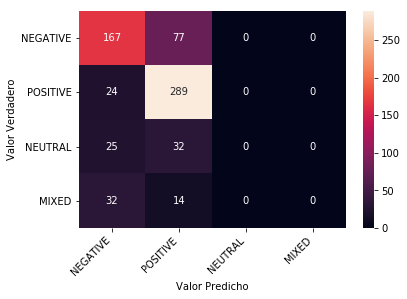

In [17]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(test_y.unique(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(test_y.unique(), rotation=45, ha='right')
plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho');

## Serializar y subir a S3

Una vez evaluado el modelo, utilizamos pickle para serializarlo en un archivo pkl y vamos a subirlo al bucket de S3.

In [18]:
filename = 'model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [19]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file('model.pkl', bucket, 'serverless/model.pkl')

## Creamos una función lambda  

A continuación vamos a crear una función lambda que tome el modelo de S3 y lo utilice para predecir. 
Debajo pueden encontrar el código para la función:


<code>
import json
import pandas as pd
from io import StringIO
import sklearn
import pickle
import boto3

s3client = boto3.client('s3')

def lambda_handler(event, context):
    bucket = event['queryStringParameters']['bucket']
    payload = event['queryStringParameters']['payload']
    df = pd.read_csv(StringIO(payload),header=None)
    #
    download_file(bucket,'serverless/model.pkl')
    loaded_model = pickle.load(open('/tmp/model.pkl', 'rb'))
    result = loaded_model.predict_proba(df.iloc[:,0])
    
    # 
    return {
        'statusCode': 200,
        'body': json.dumps({'predictions':result})
    }
   
def download_file(s3bucket,filename):
    temp_file =  '/tmp/'+ filename.split('/')[-1]
    s3client.download_file(s3bucket, filename, temp_file)
    return temp_file
    
</code>

Vamos a copiarlo y crear la función desde la consola de <a href='https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions'>AWS Lambda</a>

Una vez implementada la función lambda podemos disponibilizar esta funcionalidad a través de <a href='https://console.aws.amazon.com/apigateway/main/apis?region=us-east-1'>API Gateway</a>